In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from nilearn import plotting

from src import data,centroids,paths,matrix_filtering

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-05-09


## Settings

In [2]:
parcellations = {"DKT","MNI-HCP-MMP1","schaefer"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "DKT"
min_streamlines = 5
graph_density = 0.25

if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

fig_dir = f"ftract_results/{PARCELLATION}/{min_streamlines}/{graph_density}/"
%mkdir -p  {paths.path_figures(fig_dir)}

## Load data

### Load structural connectivity data

In [3]:
SC_matrices = []

if PARCELLATION == "DKT":
    ED = centroids.dkt_roi_distances()
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ids_to_delete_in_dkt,ED,min_streamlines_count=min_streamlines)
    centroid_coords = None

elif PARCELLATION == "MNI-HCP-MMP1":
    ftract_labels = data.load_ftract_labels(PARCELLATION)
    centroid_coords = centroids.load_glasser_centroids(ftract_labels=ftract_labels)
    ED = centroids.glasser_roi_distances(ftract_labels=ftract_labels)
    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ED=ED,min_streamlines_count=min_streamlines)

elif PARCELLATION == "schaefer":
    ED = centroids.schaefer_roi_distances()
    SC_matrices = data.load_set_of_schaefer_matrices_for_pytepfit(ED=ED,min_streamlines_count=min_streamlines)  
    centroids_file = paths.path('external/schaefer_parcellation_centroids/ROI_MAPPING_pytepfit.csv')
    centroid_coords = centroids.get_centroids_from_file(centroids_file,"geom_csv")

number_of_SC = len(SC_matrices)

load domhof
load domhof
load domhof


/home/katterrina/fi_muni/0_diplomka/src/data.py:55: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append((f"{dataset_name}_{mode}",SC_W, SC_L,np.log(SC_W)))


In [4]:
SC_matrices_filtered = []

for i, stat_data in enumerate(SC_matrices):
    name, SC_W, SC_L, SC_W_log = stat_data
    pivot = matrix_filtering.find_pivot_to_keep_xpercent_edges(SC_W,graph_density)
    SC_W = np.where(SC_W>=pivot,SC_W,0)
    if SC_L is not None:
        SC_L = np.where(SC_W>=pivot,SC_L,np.nan)
    SC_W_log = np.where(SC_W>=pivot,SC_W_log,np.nan)
    SC_matrices_filtered.append((name, SC_W, SC_L, SC_W_log))

SC_matrices = SC_matrices_filtered

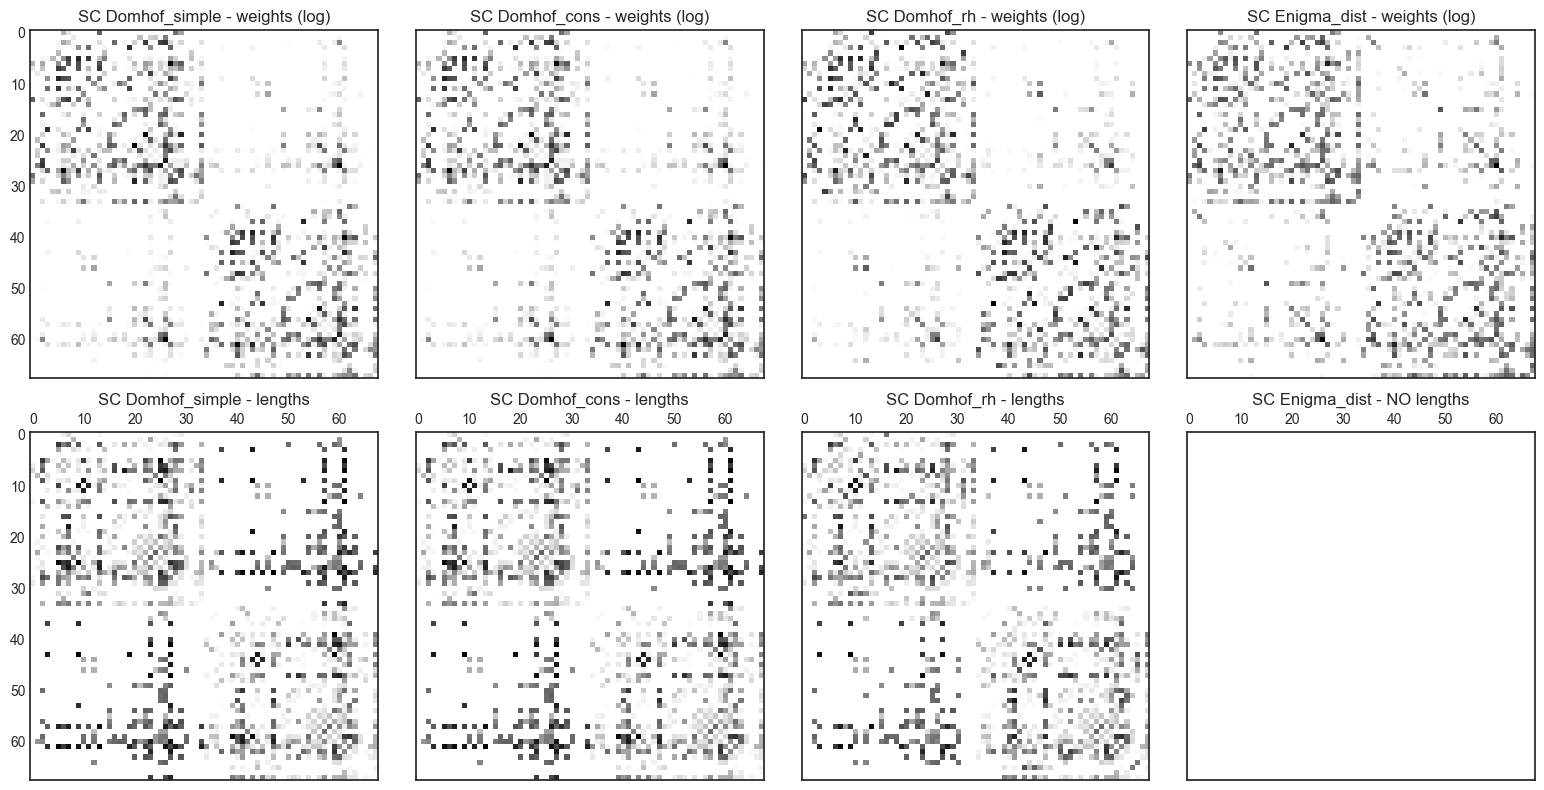

In [5]:
plt.rcParams['figure.figsize'] = [4*number_of_SC,8]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i in range(number_of_SC):
    name, SC_W, SC_L, SC_W_log = SC_matrices[i]

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")
 
    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

plt.savefig(paths.path_figures(fig_dir+"sc_matrices.pdf"))

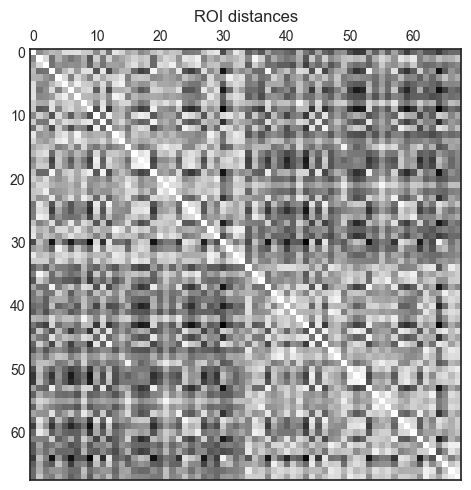

In [6]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

In [7]:
plt.style.use('ggplot')

In [8]:
dict_weights = dict()
dict_lengths = dict()

datasets_set = set()
prep_methods_set = set()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    if len(name.split("_")) >1:
        dataset,prep_method = name.split("_")
    else: 
        dataset = name
        prep_method = '-'

    datasets_set.add(dataset)
    prep_methods_set.add(prep_method)

    if dataset == "Enigma":
        SC_W = np.where(SC_W == 1, np.nan,SC_W)

    dict_weights[(dataset,prep_method)] = SC_W.flatten()
    
    if SC_L is not None:
        dict_lengths[(dataset,prep_method)] = SC_L.flatten()

df_weights = pd.DataFrame(dict_weights)
df_lengths = pd.DataFrame(dict_lengths)

df_weights

Domhof                            Enigma
        simple      cons        rh          dist
0         0.00      0.00  0.000000      0.000000
1         0.00      0.00  0.000000      0.000000
2         0.00      0.00  0.000000      0.000000
3         0.00      0.00  0.000000      0.000000
4         0.00      0.00  0.000000      0.000000
...        ...       ...       ...           ...
4619  11140.90  11140.90  0.044842  22073.632884
4620      0.00      0.00  0.000000    472.965944
4621   2094.05   2094.05  0.015580  28400.558401
4622   2463.59   2463.59  0.019228   7808.265109
4623      0.00      0.00  0.000000      0.000000

[4624 rows x 4 columns]

In [9]:
def select_df_by_dataset(df,dataset):
    return df.xs(dataset, level=0, axis=1)

def select_df_by_prep_method(df,method):
    return df.xs(method, level=1, axis=1)

In [10]:
def minmax_norm(column):
    return (column - column.min()) / (column.max() - column.min())

In [11]:
columns = list(df_weights.columns)

df_weights_normalized = df_weights.copy()

for col in columns:
    df_weights_normalized[col] = minmax_norm(df_weights_normalized[col])
df_weights_normalized

Domhof                        Enigma
        simple      cons        rh      dist
0     0.000000  0.000000  0.000000  0.000000
1     0.000000  0.000000  0.000000  0.000000
2     0.000000  0.000000  0.000000  0.000000
3     0.000000  0.000000  0.000000  0.000000
4     0.000000  0.000000  0.000000  0.000000
...        ...       ...       ...       ...
4619  0.183053  0.183053  0.240807  0.073324
4620  0.000000  0.000000  0.000000  0.001571
4621  0.034407  0.034407  0.083667  0.094340
4622  0.040479  0.040479  0.103257  0.025937
4623  0.000000  0.000000  0.000000  0.000000

[4624 rows x 4 columns]

In [12]:
df_weights.astype(bool).sum(axis=0)

Domhof  simple    1156
        cons      1156
        rh        1156
Enigma  dist      1156
dtype: int64

In [13]:
df_weights.describe().T

count         mean           std  min  25%  50%         75%  \
Domhof simple  4624.0  1449.985932   4796.170583  0.0  0.0  0.0  164.168750   
       cons    4624.0  1450.024490   4796.172792  0.0  0.0  0.0  164.168750   
       rh      4624.0     0.005536      0.016835  0.0  0.0  0.0    0.000718   
Enigma dist    4624.0  2626.124665  11029.841170  0.0  0.0  0.0   50.468594   

                         max  
Domhof simple   60861.490000  
       cons     60861.490000  
       rh           0.186216  
Enigma dist    301044.409420

In [14]:
correlations = pg.pairwise_corr(df_weights,method="spearman")
correlations

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,"(Domhof, simple)","(Domhof, cons)",spearman,two-sided,4624,1.000000,"[1.0, 1.0]",0.0,1.0
1,"(Domhof, simple)","(Domhof, rh)",spearman,two-sided,4624,0.915994,"[0.91, 0.92]",0.0,1.0
2,"(Domhof, simple)","(Enigma, dist)",spearman,two-sided,4624,0.783372,"[0.77, 0.79]",0.0,1.0
3,"(Domhof, cons)","(Domhof, rh)",spearman,two-sided,4624,0.915993,"[0.91, 0.92]",0.0,1.0
4,"(Domhof, cons)","(Enigma, dist)",spearman,two-sided,4624,0.783376,"[0.77, 0.79]",0.0,1.0
5,"(Domhof, rh)","(Enigma, dist)",spearman,two-sided,4624,0.798630,"[0.79, 0.81]",0.0,1.0


In [15]:
sns.set_theme(rc={'figure.figsize':(8,5)})
plt.style.use('ggplot')

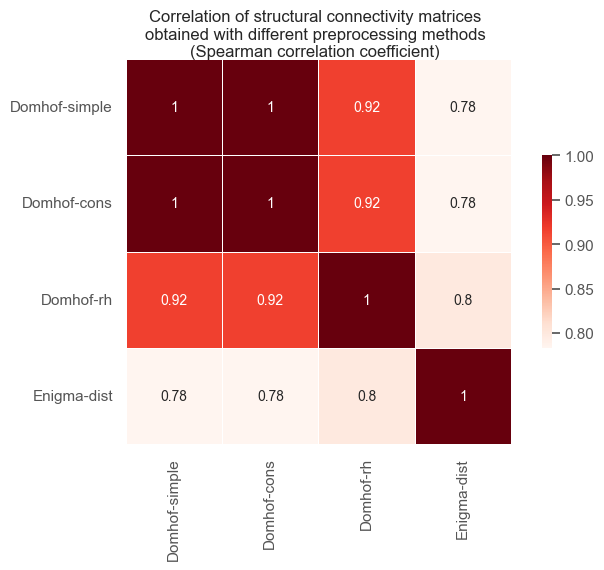

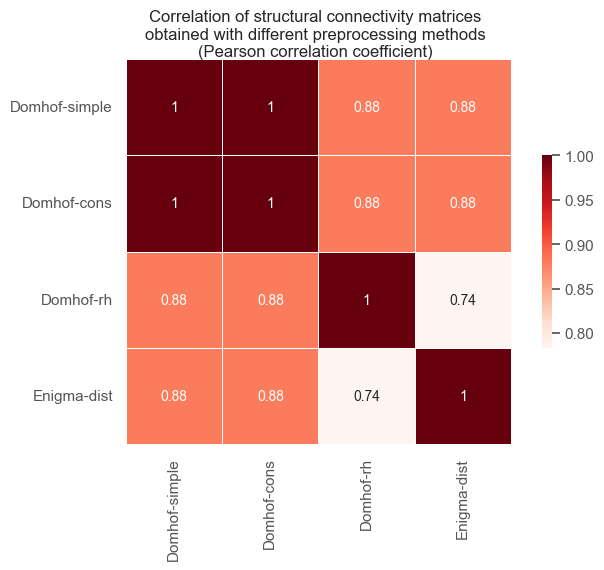

In [16]:
for corr_m in ['Spearman','Pearson']:
    ax = sns.heatmap(df_weights.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=min(correlations["r"]),
                square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
    ax.set(xlabel="", ylabel="")
    plt.suptitle(f"Correlation of structural connectivity matrices\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
    plt.savefig(paths.path_figures(fig_dir+f"correlations_all_matrices_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
    plt.show()


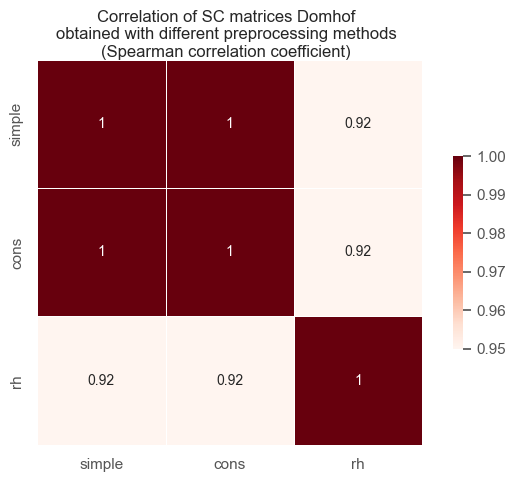

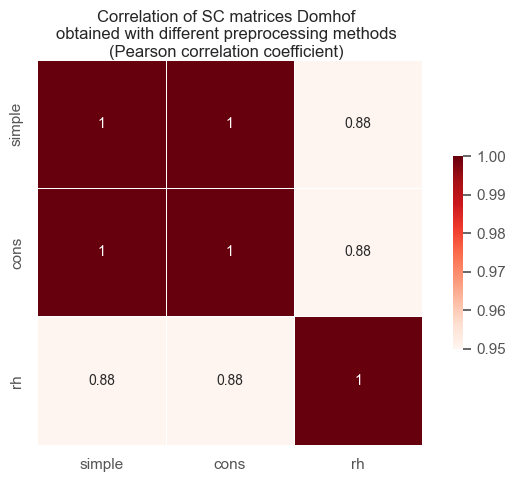

In [17]:
for corr_m in ['Spearman','Pearson']:
    for ds in ["Mica-Mics","Domhof"]:
        if ds not in datasets_set:
            continue
        df_filterd = select_df_by_dataset(df_weights,ds)
        ax = sns.heatmap(df_filterd.corr(method=corr_m.lower()), cmap="Reds",vmax=1, vmin=0.95,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
        ax.set(xlabel="", ylabel="")
        plt.suptitle(f"Correlation of SC matrices {ds}\nobtained with different preprocessing methods\n({corr_m} correlation coefficient)")
        plt.savefig(paths.path_figures(fig_dir+f"correlations_{ds}_{corr_m}.pdf"),bbox_inches='tight',pad_inches=0)
        plt.show()

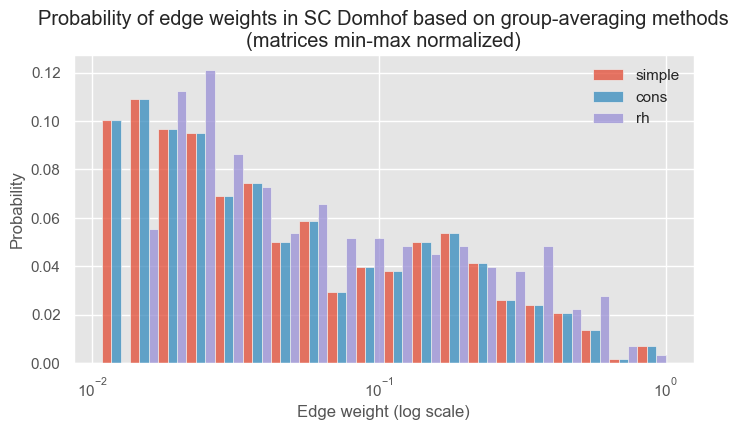

In [18]:
sns.set_theme(rc={'figure.figsize':(8,4)})
plt.style.use('ggplot')

for ds in ["Mica-Mics","Domhof"]:
    if ds not in datasets_set:
        continue
    sns.histplot(select_df_by_dataset(df_weights_normalized,ds),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC {ds} based on group-averaging methods\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

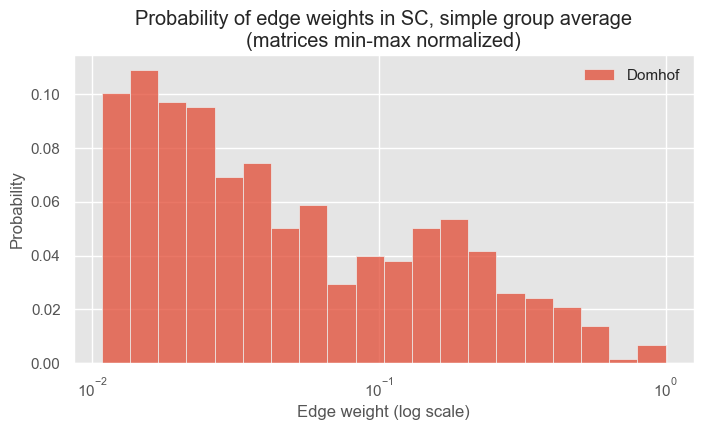

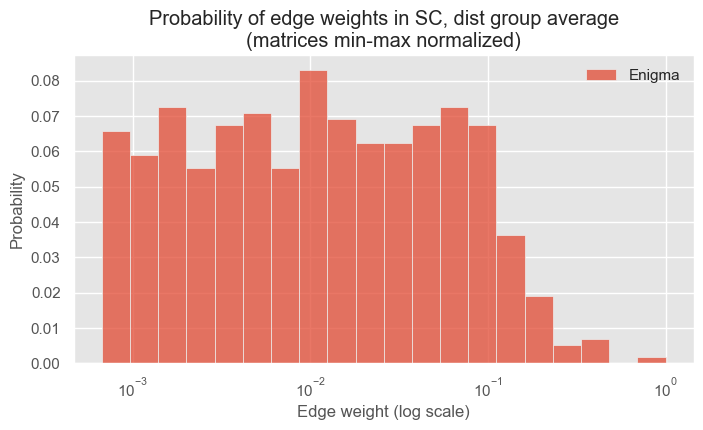

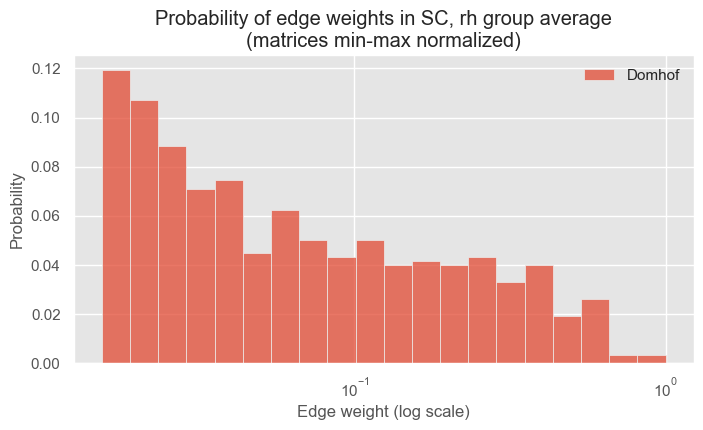

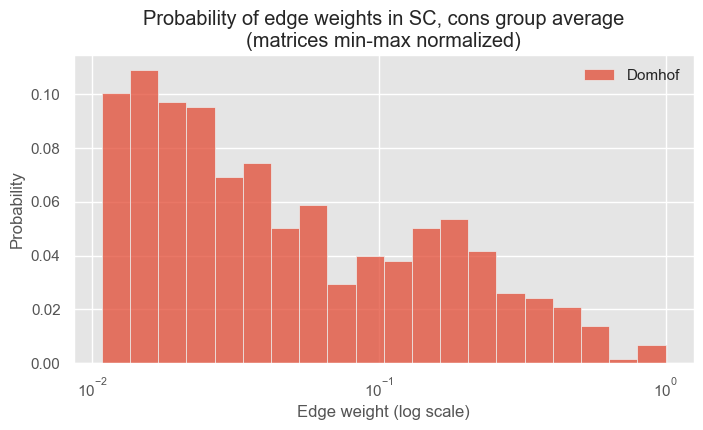

In [19]:
for m in ["simple","dist","rh","cons"]:
    if m not in prep_methods_set:
        continue
    sns.histplot(select_df_by_prep_method(df_weights_normalized,m),bins=20,log_scale=True,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge weights in SC, {m} group average\n(matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

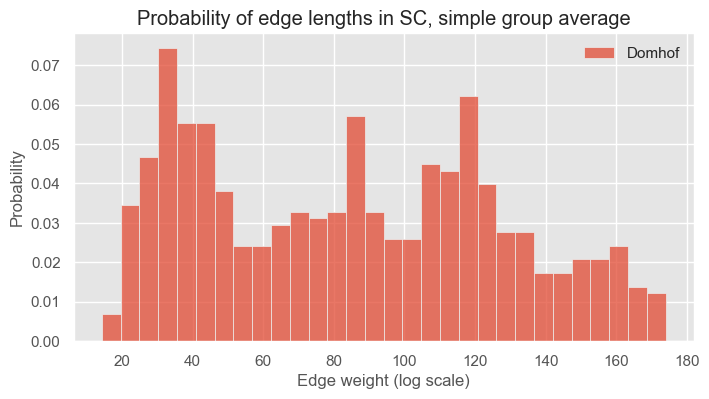

In [20]:
for m in ["simple"]:
    if m not in prep_methods_set:
        continue
    sns.histplot(select_df_by_prep_method(df_lengths,m),bins=30,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge lengths in SC, {m} group average"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()


In [22]:
if PARCELLATION != "DKT":    
    sns.histplot(select_df_by_dataset(df_lengths,'Mica-Mics'),bins=20,multiple="dodge",stat="probability",common_norm=False)
    plt.xlabel("Edge weight (log scale)")
    title = f"Probability of edge lengths in SC by preprocessing method\nMica-Mics dataset (matrices min-max normalized)"
    plt.title(title)
    image_name = (title.replace("\n","_")).replace(" ","_")
    plt.savefig(paths.path_figures(fig_dir+f'{image_name}.pdf'),bbox_inches='tight',pad_inches=0)
    plt.show()

In [23]:
if centroid_coords is not None:
    # the coordinates are not in MNI space, so we shift them manually for plotting reasons
    for i in range(3):
        centroid_coords[:,i] = centroid_coords[:,i] - ((centroid_coords[:,i].max()-centroid_coords[:,i].min())/2+centroid_coords[:,i].min())
    centroid_coords[:,1]-=12
    centroid_coords[:,2]+=15


    fig, ax= plt.subplots(len(SC_matrices),1,figsize=(15,len(SC_matrices)*5),sharex=True,sharey=True)
    n_edges = 2000

    fig.suptitle(f"Average structural connectivity matrices, log-transformed and min-max normalized, {n_edges} strongest edges")

    for i,d in enumerate(SC_matrices):
        name, SC_W, _, SC_W_log = d
        m = np.nan_to_num(SC_W_log,nan=np.nan,posinf=np.nan,neginf=np.nan)

        m = (m - np.nanmin(m,axis=None))
        m = m/np.nanmax(m,axis=None)

        np.fill_diagonal(m,0)
        pivot = data.find_pivot_to_keep_x_edges(m,x=n_edges)
        m = np.where(m>pivot,m,0)

        plotting.plot_connectome(m,centroid_coords,axes=ax[i],node_color="k",node_size=10,title=name,colorbar=True,edge_cmap='Reds',edge_vmin=0.7,edge_vmax=1)

    plt.savefig(paths.path_figures(fig_dir+"connectomes_brain.pdf"))